In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = "/home/victor/Datasets/ml"

# Калибровка вероятностей

Часто при обучении моделей для бинарной классификации хочется получать не только предсказанную метку класса, но и вероятность положительного класса. Предсказанная вероятность может служить как мера уверенности нашего алгоритма. Также это позволяет сравнивать две модели, у которых одинаковые метрики точности. Этот тип метрик конкретно используется в высокорисковых приложениях, позволяя нам не рассматривать результаты модели как реальные вероятности, а вместо этого выходить за рамки необработанных результатов и предотвращать плохое принятие решений или ложную интерпретацию.

В задаче бинарной классификации откалиброванным алгоритмом называют такой алгоритм, для которого доля положительных примеров (на основе реальных меток классов) для предсказаний в окрестности произвольной вероятности $\hat p$ совпадает с этим значением $p$. Например, если взять объекты, для которых предсказанные вероятности близки к 0.7, то окажется, что среди них 70\% принадлежат положительному классу.
На математическом языке это выглядит так: если $\hat p$  — предсказанная вероятность класса 1, то $P(y=1|q(x_i)=\hat p)=\hat p$.

Однако некоторые алгоритмы не выдают корректные вероятности классов. В таком случае вероятности модели нужно калибровать.

Для визуализации откалиброванности алгоритма можно построить калибровочную кривую. На этой кривой абсцисса точки соответствуют значению $p$ (предсказаний алгоритма), а ордината соответствует доле примеров, для которых алгоритм предсказал вероятность, близкую к $p$. В идеальном случае эта кривая совпадает с прямой $y = x$. 

Чаще всего  $\hat p$ - это какие-то вещественные числа, которые будут разными для разных $y_i$. Для того, чтобы оценить именно вероятности, отрезок $[0, 1]$ можно разбить на бины, и для каждого бина вычислить долю класса 1 и,соответственно, среднюю предсказанную вероятность.

Пример диаграммы калибровки: 

![calib_1](../additional_materials/images/calib_1.png)


У идеально откалиброванной модели зеленая и розовая линии должны совпадать. Однако в нашем случае модель завышает свою оценку. Как отделить положительные примеры от отрицательных (дать дискретный класс)? Обычно пользуются порогом (логично сделать 0.5). Но нам придется сдвинуть порог вправо - так, чтобы разбить зеленый график пополам по вертикали.

Часто картинка иная. В таком случае говорят о слишком увернной модели (overconfident) или неуверенной (underconfident). В первом случае молдель предсказывает вероятности ближе к экстремальным, ченм стоит (0.1 вместо 0.2 и 0.9 вместо 0.1), во втором же наоборот, сводит все вероятности к центру интервала.

![calib_2](../additional_materials/images/calib_2.png)

Часто слишком большой уверенностью грешат нейросети, так как их учат именно на метках классов. Способ с этим бороться - Label smoothing, когда вместо метки класса модели дают слегка сглаженное значение (0.9 вместо 1, и т.д.). Альтернативный путь - hard samples mining, когда мы заставляем модель больше обращать внимания на объекты ближе к границе разделения.

Второй же случай возникает, если мы, наоборот, слишком сильно уделяем внимание границе. Это часто происходит в SVM или бэггинге.

In [3]:
data = pd.read_csv(data_path + '/' + 'riceClassification.csv')


Отмасштабируем данные и подготовим трейн и тест.

In [4]:
X = data.drop(columns=['id', 'Class'])
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=999)
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Задание**: Оцените сбалансированность классов

In [5]:
data["Class"].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

Обучим метод опорных векторов (SVC — Support Vector Classification) и логистическую регрессию, в качестве метрики возьмем ROC-AUC. 
В качестве скоров будем рассматривать выход decision_function. Этот метод возвращает confidence score для семплов и пропорционален расстоянию до разделяющей гиперплоскости, взятого со знаком. Он вернет матрицу размера (n_samples, n_classes). В бинарном случае, будет возвращен скор для класса 1.

Вопрос: Какая формула для decision function у логистической регрессии?

In [6]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.9991453206707389


In [7]:
svc_pred

array([ 3.25919713,  1.95223252,  1.93751674, ...,  0.46630054,
        2.95728847, -1.77506553])

In [8]:
svc.predict(X_test)

array([1, 1, 1, ..., 1, 1, 0])

In [9]:
print('SVC ROC-AUC (on predictions):', roc_auc_score(y_test, svc.predict(X_test)))

SVC ROC-AUC (on predictions): 0.9894067537906887


In [ ]:
# предскажите вероятности с помощью SVM

In [10]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.decision_function(X_test)
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.9990017675125695


In [11]:
lr.predict(X_test)

array([1, 1, 1, ..., 1, 1, 0])

In [12]:
lr.predict_proba(X_test)

array([[7.52180938e-05, 9.99924782e-01],
       [2.37484102e-03, 9.97625159e-01],
       [4.28557243e-03, 9.95714428e-01],
       ...,
       [1.72933989e-01, 8.27066011e-01],
       [2.10618110e-04, 9.99789382e-01],
       [9.98955458e-01, 1.04454161e-03]])

In [13]:
lr.classes_

array([0, 1])

Суда по метрике, мы практически идеально предсказываем класс.

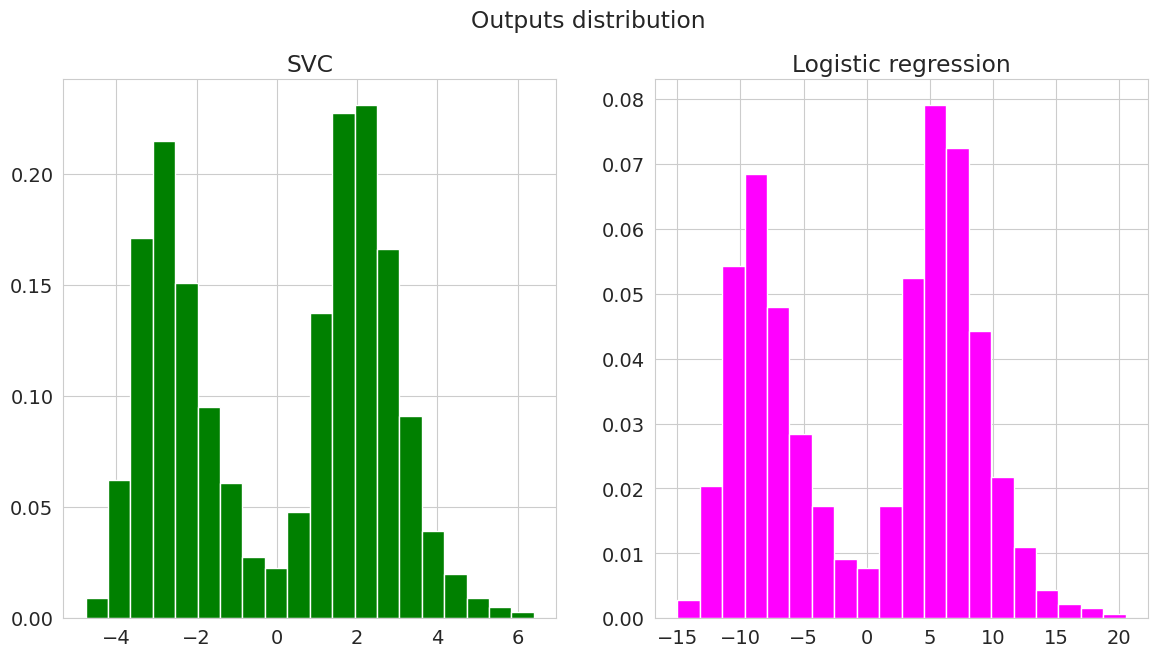

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='green', density='True')
axs[1].hist(lr_pred, bins=20, color='magenta', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

Мы видим, что скоры могут принимать любые вещественные значения. Но для оценивания вероятностей нам нужно перевести их в промежуток 
$[0,1]$. С логистической регрессией несложно: можно добавить сигмоиду или софтмакс, ведь модель и обучалась так, чтобы $\sigma (W^Tx)$
 приближало вероятности. Для SVC у нас нет такой опции, поэтому воспользуемся масштабированием через минимум-максимум.

In [15]:
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
lr_pred = lr.predict_proba(X_test)[:, 1]

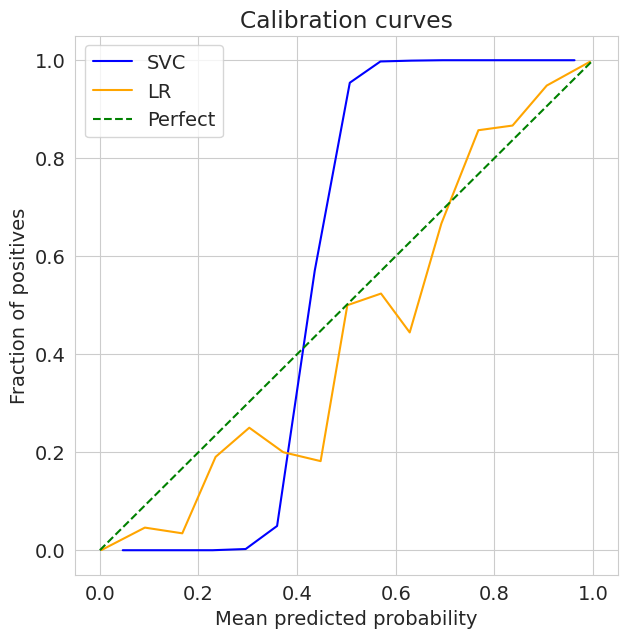

In [16]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


Мы видим, что кривая для логистической регрессии неплохо приближает диагональ. С SVC все гораздо хуже. Но попробуем откалибровать модели разными способами.

**Задание**: Постройте гистограмму предсказанных вероятностей для двух классификаторов.

In [17]:
svc_pred_prob

array([0.04648647, 0.10733276, 0.16684225, 0.228708  , 0.29573532,
       0.35946427, 0.43577544, 0.50688202, 0.56895984, 0.6318943 ,
       0.69518912, 0.7620902 , 0.82502414, 0.89996083, 0.96254257])

In [ ]:
# YOUR CODE: Plot preds

# Калибровка Платта
Пусть наш алгоритм выдаёт значения $f(x)$ (могут не быть вероятностями). Тогда итоговая вероятность строится как:

$$P(y = 1 | x) = \frac{1}{1+\exp (af(x) + b)},$$

где $a, b$ -- скалярные параметры. Эти параметры настраиваются методом максимума правдоподобия (минимизируя логистическую функцию потерь) на отложенной выборке. Также Платт предложил настраивать параметры на обучающей выборке базовой модели, а для избежания переобучения изменить метки объектов на следующие значения:

$$ t_{+} = \frac{N_{+} + 1}{N_{-} + 2}$$

 для положительных примеров и

$$ t_{-} = \frac{1}{N_{-} + 2}$$

 для отрицательных.

Калибровку Платта можно представить как применения логистической регрессии поверх предсказаний другого алгоритма с отключенной регуляризацией. 
Калибровка Платта неплохо справляется с SVM, но для более хитрых классификаторов может спасовать. В целом, можно показать, что этот метод хорошо работает, если для каждого из истинных классов предсказанные вероятности распределены нормально с одинаковыми дисперсиями (подробнее [здесь](https://research-information.bris.ac.uk/ws/portalfiles/portal/154625753/Full_text_PDF_final_published_version_.pdf)). 

Вообще эта калибровка относится к большой группе параметрических методов калибрации, туда же относится бета-калибрация (в предположении бета-распределения) или калибрация Дирихле (для мультикласса). 

In [20]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.9991337204155334


In [22]:
sigmoid_lr = CalibratedClassifierCV(lr, method='sigmoid').fit(X_train, y_train)
sigmoid_lr_pred = sigmoid_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.9989893277652108


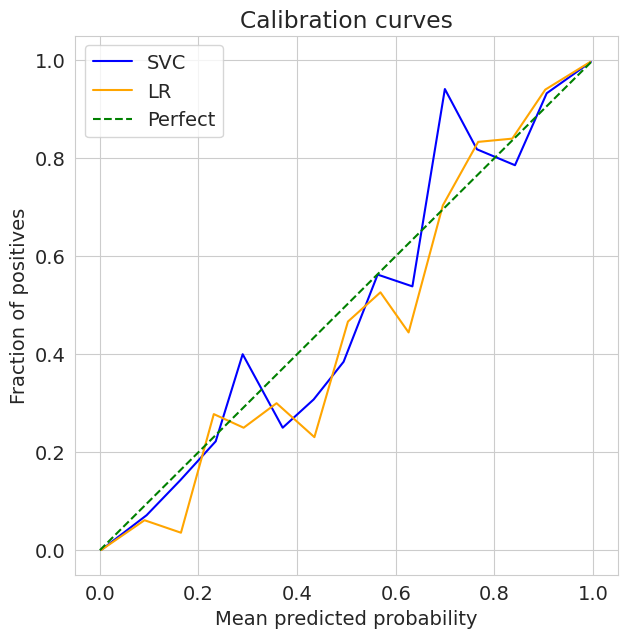

In [24]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


Как мы видим, калибровка Платта действительно улучшила вероятности, который получаются у SVC. При этом кривая для логистической регрессии практически не сдвигается. 

# Изотоническая регрессия
В этом методе также строится отображение из предсказаний модели в откалиброванные вероятности. Для этого используем изотоническую функцию (неубывающая кусочно-постоянная функция), в которой $x$ -- выходы нашего алгоритма, а $y$ -- целевая переменная. 

Мы хотим найти такую функцию $m(t)$: $P(y = 1 | x) = m(f(x))$. Она настраивается под квадратичную ошибку:

$$m = \arg \min_{z} \sum (y_i - z(f(x_i))^2,$$

с помощью специального алгоритма (Pool-Adjacent-Violators Algorithm), изучать который в этом курсе мы не будем.

В результате калибровки получаем надстройку над нашей моделью, которая применяется поверх предсказаний базовой модели. В случае мультиклассовой классификации каждый класс калибруется отдельно против остальных (one-versus-all), вероятности при предсказании нормируются.

Этот метод склонен к переобучению, поэтому его рекомендуется применять только для больших выборок.


In [29]:
isotonic_svc = CalibratedClassifierCV(svc, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.9990992249197903


In [33]:
# YOUR CODE: Make the same for LR
isotonic_lr = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_lr_pred = isotonic_lr.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.9989381569026097


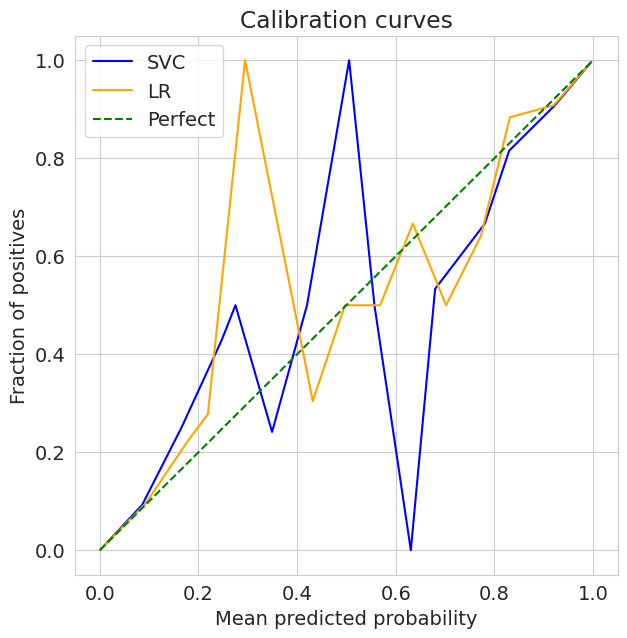

In [34]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


Изотоническая регрессия немного подпортила кривую калибрации для линейной регрессии. Судя по всему, этот метод немного переобучился, хоть у нас и есть достаточно большая выборка.

## Мультикласс
У нас есть как минимум три варианта определить, что означает мультиклассовая калиброванность. Например, по мере увеличения строгости:
1) Учитывать только самую высокую вероятность. Для него мы требуем, чтобы среди всех случаев, где вероятность наиболее вероятного класса прогнозируется как $c$, ожидаемая точность была бы $c$. $P(Y=i|\hat p_i(x)=q_i)=q_i, i=\arg\max_j \hat p_j (X)$
2) Учитывать маргинальные вероятности. Тут мы хотим, чтобы все one-vs-rest вероятности были откалиброваны: $P(Y=i|\hat p_i(x)=q_i)=q_i, i=1...k$.
3) Учитывать весь вектор вероятностей. Т.е. чтобы пропорции классов для семплов с определенным вектором предсказаний былит такие же, как и весь вектор предсказаний:  $P(Y=i|\hat p(x)=q)=q_i, i=1...k$. 
   
Чаще всего используется определение слабой калиброванности (1). Однако, в случае чувствительной к стоимости постановки задачи оно может быть слишком слабым.


## Оценка качества калибровки

Мы что-то поняли по графикам, но как оценить численно улучшение предсказания вероятностей? Для этого есть свои метрики.

**Maximum calibration error**. Самый простой способ, впрочем — он наследник идеи с калибровочной кривой. А именно, разобьём отрезок 
$[0,1]$ на бины $B_1, B_2, ..., B_k$ по предсказанным вероятностям и вычислим следующее:
$$ \max_{j=1,..,k}|{\overline y(B_k) - \overline q (B_k) }|$$
Иными словами, посчитаем максимальную разницу между точностью и уверенностью модели в бинах.

**Expected Calibration Error (ECE)** считает среднюю разницу: $$ \sum^k_{j=1}{{\|B_j\|}\over{N}}{| {\overline y(B_k) - \overline q (B_k) }|},$$
где $\|B_j\|$ - число семплов в бине.

Проблема этих способов в том, что мы можем очень по-разному предсказывать в каждом из бинов вероятности (в том числе константой) без ущерба для метрики.

Применим метрику калибрации:

In [37]:
from pycalib.metrics import binary_ECE

print("Platt:")
print('SVC binary-ECE = ', binary_ECE(y_test, sigmoid_svc_pred ))
print('Linear binary-ECE = ', binary_ECE(y_test, sigmoid_lr_pred))

print("Isotonic:")
print('SVC binary-ECE = ', binary_ECE(y_test,isotonic_svc_pred ))
print('Linear binary-ECE = ', binary_ECE(y_test, isotonic_lr_pred))

Platt:
SVC binary-ECE =  0.003987368753052011
Linear binary-ECE =  0.002239762777264194
Isotonic:
SVC binary-ECE =  0.002233490958613342
Linear binary-ECE =  0.002239762777264194


**Задание**: Посчитайте метрику для неоткалиброванного классификатора.

**Вопрос**: Как можно адаптировать MCE/ECE для мультиклассовой задачи? Напишите формулы.
*Ответ*: использовать выигравший класс. Можно сделать бинарные есе для всех классов и потом усреднить по классам.

В случае мультикласса, у нас возникает несколько сложностей: во-первых, в случае большого числа классов число бинов будет очень большим, при этом многие будут пустыми. Да и само определение реальной ECE пока не сделано. 

Можно посчитать калиброванность и на уровне семплов.

**Brier score.** Тоже одна из популярных метрик, которая попросту измеряет разницу между предсказанными вероятностями и $ y_i $ (обратите внимание, что $ y_i $  - это либо 0, либо 1):
$$ \sum^N_{i=1}(y_i - q (x_i))^2,$$ 
для бинарного случая, и
$$ {1 \over N} \sum^N_{n=1}\sum^K_{j=1} (I(y_n=j) - q_{nj})^2,$$ 
для мультикласса.

**Вопрос**: Какое значение соответствует лучшей калибрации? Какие максимальные и минимальные значения он можеит принимать?

Также можно использовать log-loss:
$$ {-1\over N} {\sum^N_{n=1}\sum^K_{j=1}I(y_n=j)log(q_{n,j})}$$

Для достаточно гладких классификатора и датасета brier score и log-loss будут адекватными средствами оценки, но если нет — возможно всякое.

In [38]:
from pycalib.metrics import brier_score

print("Platt:")
print('SVC brier score = ', brier_score(y_test, sigmoid_svc_pred ))
print('Linear brier score  = ', brier_score(y_test, sigmoid_lr_pred))

print("Isotonic:")
print('SVC brier score  = ', brier_score(y_test,isotonic_svc_pred ))
print('Linear brier score = ', brier_score(y_test, isotonic_lr_pred))

Platt:
SVC brier score =  0.00819079896489812
Linear brier score  =  0.008753390327467442
Isotonic:
SVC brier score  =  0.008210667088108598
Linear brier score =  0.008753390327467442


**Задание**: Посчитайте метрику для неоткалиброванного классификатора.

Итак, мы откалибровали наши классификаторы. Теперь мы можем оценить, как поменяются метрики после этого. Так, по идее точность, f1 не должны сильно поменяться, так как вблизи от границы разделения вероятности не должны сильно измениться. Так ли это?
Теперь **вопрос**: Изменится ли ппосле калибрации ROC-AUC и как? Можете ли вы ответить на вопрос без измерений?

**Задание**: Обучите дерево решений и случайный лес.

Logistic regression ROC-AUC: 0.9834268222321944
Logistic regression ROC-AUC: 0.9982100882535205


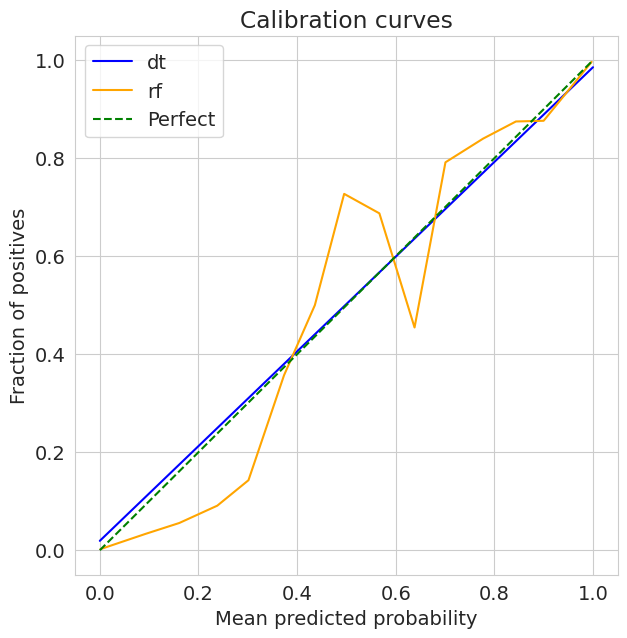

In [46]:
# YOUR CODE: 
# 1) train DT, RF
# 2) output scores for these models
dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred = dt.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, dt_pred))

rf = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)[:, 1]
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, rf_pred))

plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, dt_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, rf_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='dt', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='rf', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


**Задание**: Откалибройте изотоническим методом. Постройте калибровочные кривые для классификаторов, до и после калибровки.

In [ ]:
# YOUR CODE: 
# 1) make isotonic calibration
# 2) make sigmoid calibration
isotonic_dt = CalibratedClassifierCV(dt, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_dt_pred = isotonic_dt.predict_proba(X_test)[:, 1]
print('dt ROC-AUC:', roc_auc_score(y_test, isotonic_dt_pred))

isotonic_rf = CalibratedClassifierCV(dt, cv=3, method='isotonic').fit(X_train, y_train)
isotonic_rf_pred = isotonic_rf.predict_proba(X_test)[:, 1]
print('rf ROC-AUC:', roc_auc_score(y_test, isotonic_rf_pred))

Logistic regression ROC-AUC: 0.992938802548393
Logistic regression ROC-AUC: 0.9933748805631618


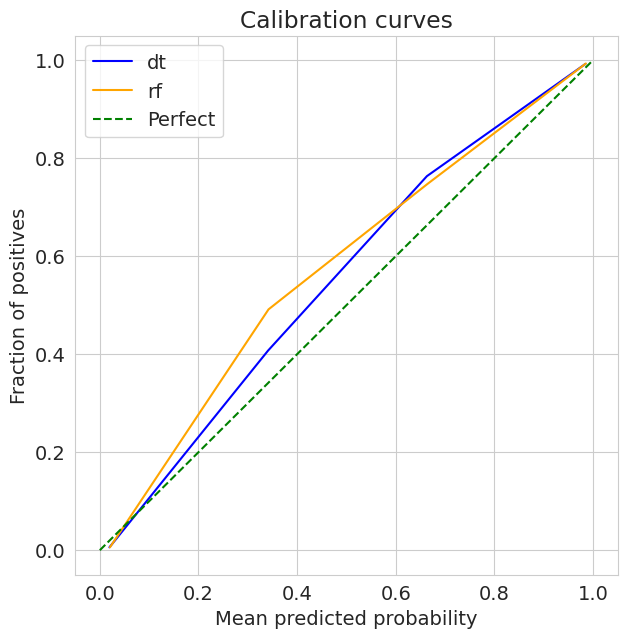

In [52]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_dt_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, isotonic_rf_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='dt', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='rf', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


In [53]:
sigmoid_dt = CalibratedClassifierCV(dt, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_dt_pred = sigmoid_dt.predict_proba(X_test)[:, 1]
print('dt ROC-AUC:', roc_auc_score(y_test, isotonic_dt_pred))

sigmoid_rf = CalibratedClassifierCV(dt, cv=3, method='sigmoid').fit(X_train, y_train)
sigmoid_rf_pred = sigmoid_rf.predict_proba(X_test)[:, 1]
print('rf ROC-AUC:', roc_auc_score(y_test, isotonic_rf_pred))

dt ROC-AUC: 0.992938802548393
rf ROC-AUC: 0.9933748805631618


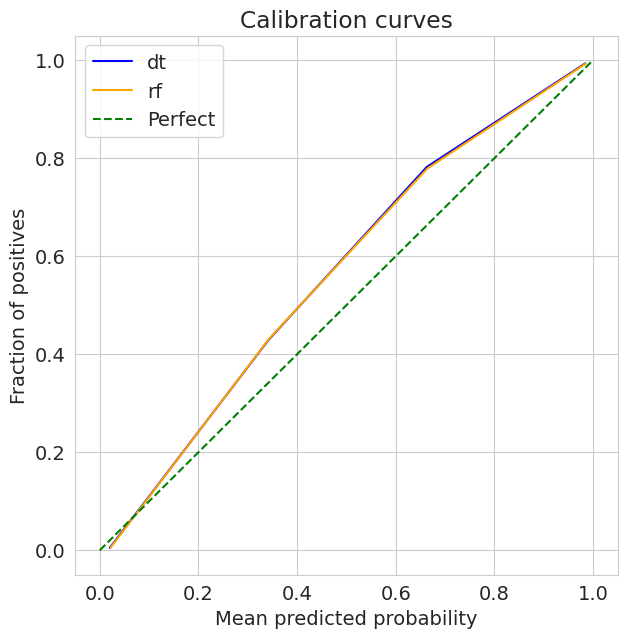

In [54]:
plt.figure(figsize=(7, 7))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_dt_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, sigmoid_rf_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label='dt', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='rf', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


ВОпрос: Какой вывод можно сделать из графиков?

**Задание**: Какой из классификаторов в итоге лучше откалиброван (среди всех)? Покажите в сравнении. Какой вы выберете далее?